# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
import re
import spacy
import nltk

from tqdm.auto import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords




In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.duplicated().sum()

0

In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews['sp'].value_counts()

neg    23715
pos    23616
Name: sp, dtype: int64

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Encontramos un DataFrame muy limpio sin valores duplicados aunque si con valores nulos sin embargo esos datos decidi dejarlos ya que no afectan al aprendizaje del modelo siendo que unicamente ocupamos las reseñas ademas vemos que en otras columnas tienen datos pero no nos dicen nada unicamente son signos sin informacion.
En cuanto al desequilibrio de clases no lo tenemos ya que esta bastante balanceado con apenas 100 reseñas positivas mas por lo que esto no nos preocupa.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


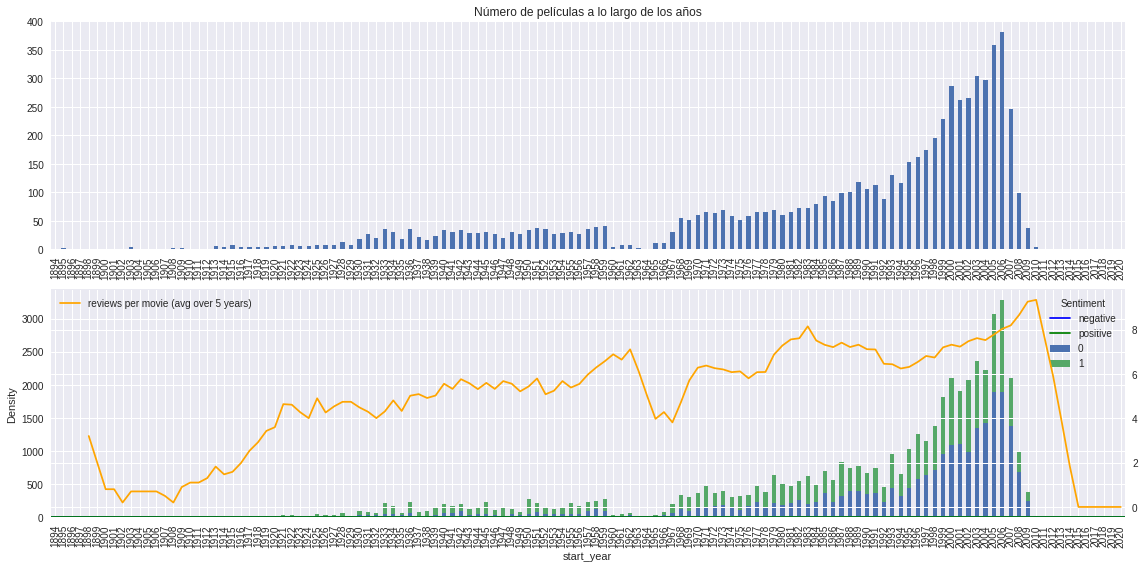

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)
sns.kdeplot(dft2[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft2[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend(title='Sentiment')

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
axt.legend(lines, labels + ['reviews per movie'], loc='upper left')  

fig.tight_layout()

plt.show()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

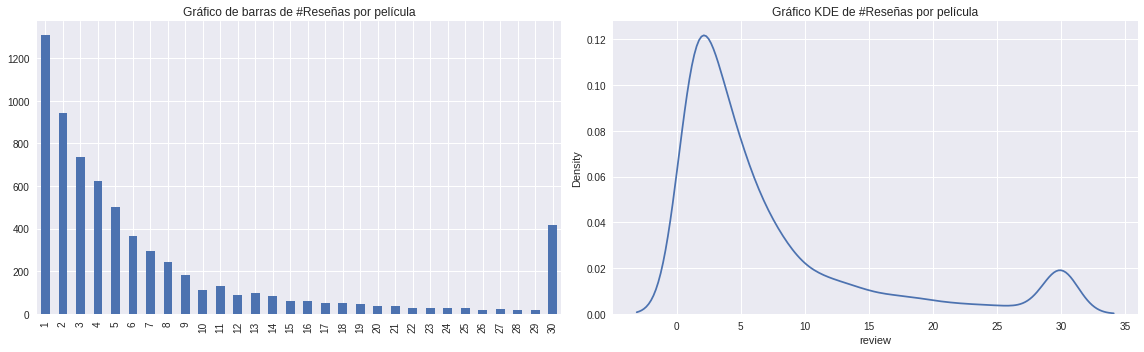

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

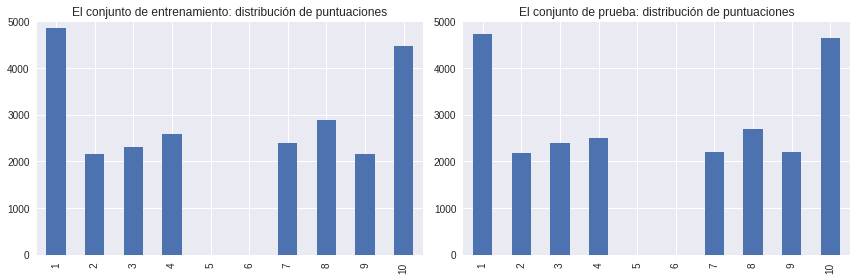

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Como mencionamos antes las muestras de entrenamiento y testeo tienen distribuciones extremadamente similares. No tenemos que preocuparnos por que las muestras nos lleven a conclusiones erradas.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


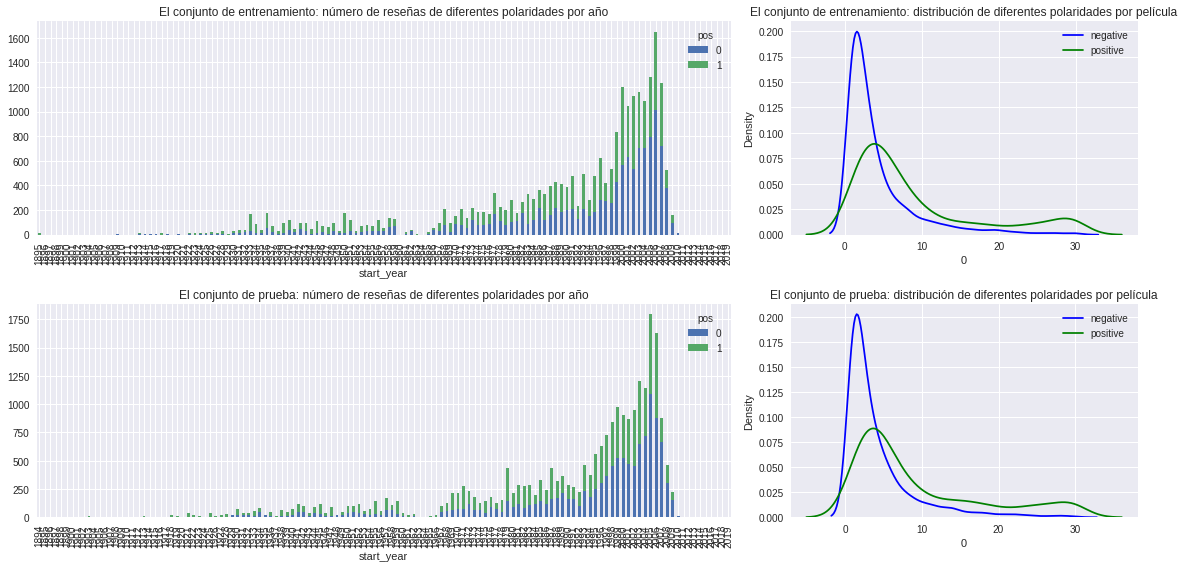

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Aunque en este caso las diferencias son un poco más notorias, siguen siendo muestras parecidas con similares distribuciones.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(text):

    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())

    return clean_text.lower()


def lemmatize(text):

    doc = nlp(text.lower())

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [18]:
%%time
review_norm = []
for c in df_reviews['review']:
    review_norm.append(lemmatize(clear_text(c)))

df_reviews['review_norm'] = review_norm # <escribe tu código aquí>

CPU times: user 17min 25s, sys: 8.28 s, total: 17min 33s
Wall time: 17min 34s


In [19]:
df_reviews['review_norm'].loc[1]

'how the hell do they get this make present itself as a caper comedy the misbegotten be essentially two hour of people mumble sentence fragment the usually dependable warren beatty look drunk and the usually hilarious goldie hawn act like she be on depressant as for gert frobe his most famous role goldfinger be infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness be I compare this movie to plan from outer space I would not do such a thing even if someone pay I p fos be idiotically make but end up hilarious this be idiotically make and cause you to feel like your brain just melt out of your ear warren beatty and goldie hawn make up for this when they co star in shampoo but then they co star in the dreadful town country maybe they just should not co star in movie all in all I would rather have my skin tear off than have to watch this again awful maybe they should remake it with jackie chan then I would p

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


Ya teniamos definidos los datos para entrenamiento y prueba solo se separaron.

## Trabajar con modelos

### Modelo 0 - Constante

In [21]:
dummy = DummyClassifier(strategy="most_frequent").fit(train_features, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


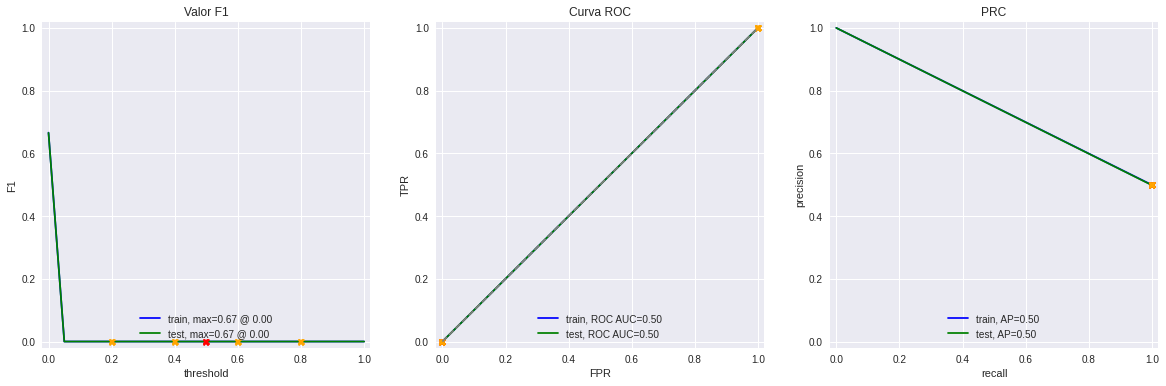

In [22]:
evaluate_model(dummy, train_features, train_target, test_features, test_target)

Tenemos una linea base desde la cual comparar el resto de los modelos, continuemos.

### Modelo 1 - NLTK, TF-IDF y LR

In [23]:
corpus = df_reviews['review_norm']

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf = count_tf_idf.fit_transform(corpus)

df_reviews['tf_idf'] = tf_idf

In [24]:
train_corpus = df_reviews_train['review_norm']
train_features_1 = count_tf_idf.transform(train_corpus)

test_corpus = df_reviews_test['review_norm']
test_features_1 = count_tf_idf.transform(test_corpus)

#train_features_1 = df_reviews_train['tf_idf']
#test_features_1 = df_reviews_test['tf_idf']

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


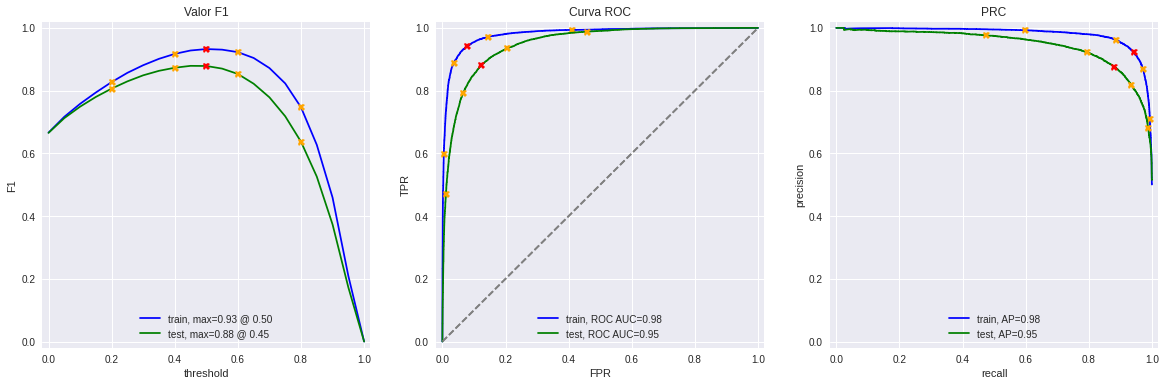

In [25]:
reg = LogisticRegression().fit(train_features_1, train_target)
evaluate_model(reg, train_features_1, train_target, test_features_1, test_target)

En este primer modelo superamos el valor F1 que se nos solicitaba llegando a .88 con los datos de prueba.

### Modelo 2 - spaCy, TF-IDF y LR

In [26]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [28]:
%%time
vectorizer = TfidfVectorizer()

train_features_spacy = df_reviews_train['review_norm'].apply(text_preprocessing_3)
test_features_spacy = df_reviews_test['review_norm'].apply(text_preprocessing_3)

CPU times: user 17min 5s, sys: 373 ms, total: 17min 5s
Wall time: 17min 5s


In [29]:
train_features_spacy_2 = vectorizer.fit_transform(train_features_spacy)
test_features_spacy_2 = vectorizer.transform(test_features_spacy)

In [30]:
reg_2 = LogisticRegression()
reg_2.fit(train_features_spacy_2, train_target)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


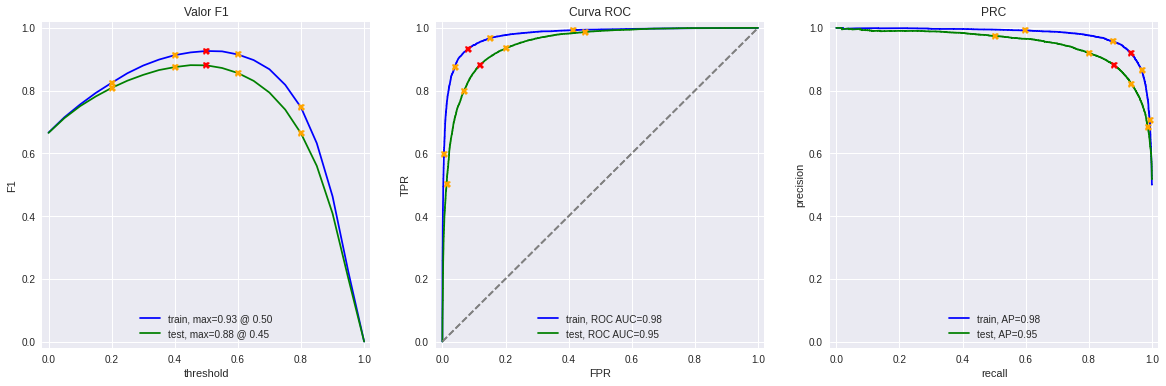

In [31]:
evaluate_model(reg_2, train_features_spacy_2, train_target, test_features_spacy_2, test_target)

Los resultados de este modelo fueron los mismos que en el anterior.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [32]:
light = LGBMClassifier()
light.fit(train_features_1, train_target, eval_metric = 'RMSE', eval_set=(test_features_1, test_target), verbose=0)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


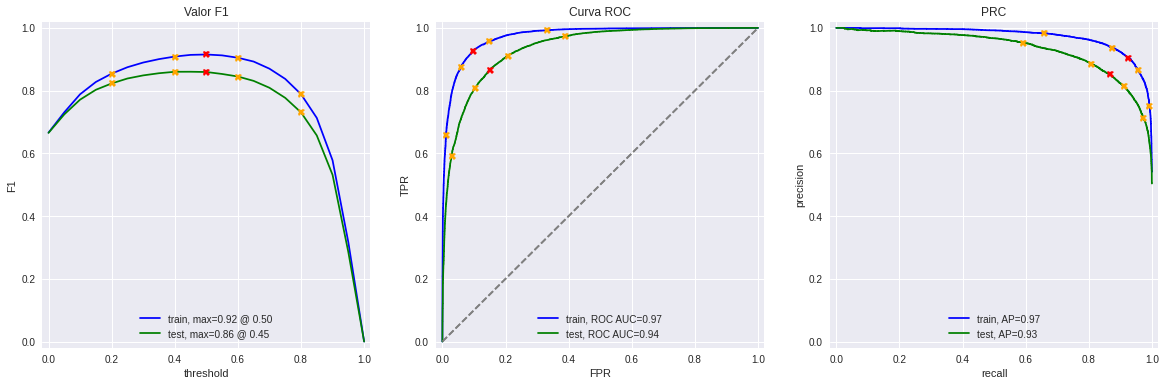

In [33]:
evaluate_model(light, train_features_1, train_target, test_features_1, test_target)

En este primer modelo de potenciacion de gradiente los resultados fueron ligeramente menores a los anteriores y apenas superamos la puntuacion F1 que se nos solicita.

### Modelo 4 - spaCy, TF-IDF y CatBoost

In [34]:
cat = CatBoostClassifier(iterations=200, silent=True)
cat.fit(train_features_1, train_target, eval_set=(test_features_1, test_target))

          train  test
Accuracy   0.90  0.86
F1         0.90  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


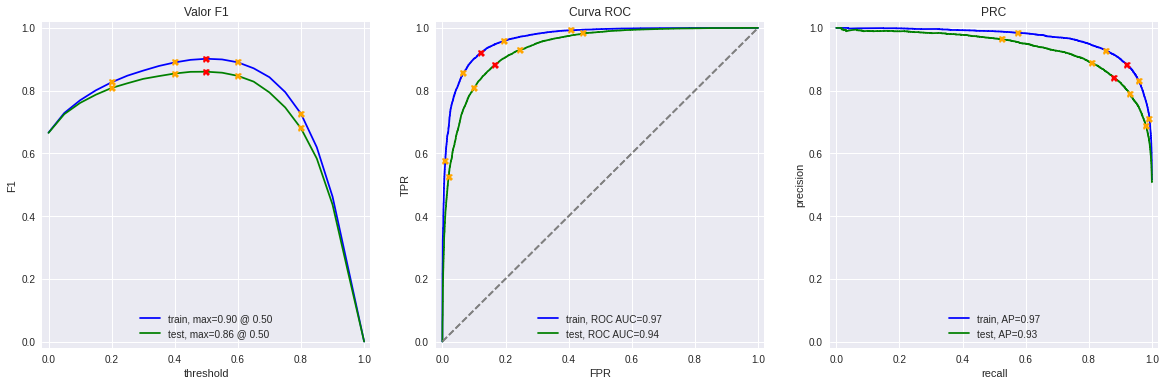

In [35]:
evaluate_model(cat, train_features_1, train_target, test_features_1, test_target)

El resultado de este otro modelo de potenciacion de gradiente es el mismo que el anterior, en esta ocacion estos modelos tuvieron menor desempeño que la regresion logistica.

## Mis reseñas

In [36]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews_norm = []
for c in my_reviews['review']:
    my_reviews_norm.append(lemmatize(clear_text(c)))

my_reviews['review_norm'] = my_reviews_norm # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


### Modelo 1 NLTK, TF_IDF y LR

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = reg.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.12:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.28:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 2 spaCy, TF_IDF y LR

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = reg_2.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  I do not simply like it not my kind of movie
0.21:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.14:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.19:  I do not expect the reboot to be so good writer really care about the source material
0.68:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.87:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 3 spaCy, TF_IDF y LGBMClassifier

In [39]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = light.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  I do not simply like it not my kind of movie
0.39:  well I be bored and feel asleep in the middle of the movie
0.60:  I be really fascinated with the movie
0.37:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.74:  I do not expect the reboot to be so good writer really care about the source material
0.72:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.27:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.81:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 4 spaCy, TF_IDF y CatBoost

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = cat.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  I do not simply like it not my kind of movie
0.46:  well I be bored and feel asleep in the middle of the movie
0.57:  I be really fascinated with the movie
0.42:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.66:  I do not expect the reboot to be so good writer really care about the source material
0.59:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.30:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.74:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


## Conclusiones

A lo largo del proyecto hemos evaluado un modelo base Dummy y otros 4 modelos que nos permitieron predecir el sentimiento de la reseña. Estos 4 modelos han obtenido un valor de F1 mayor a 0.85, con lo que todos han logrado superar la marca mínima.

Dicho esto, si vemos las probabilidades de predicción, podemos ver que el modelo *cat* y *light* tienen respuestas muy similares. Estos modelos funcionan de maneras similares, por lo que el hecho de que sus resultados también lo sean no es sorprendente, pero al momento de analizar los modelos con las reseñas vemos variaciones bastante notorias aunque no llegan a ser contradictorias, lo mismo sucede con los dos modelos de Regresion Logistica ya que los resultados de la metrica F1 sin iguales pero al momento de pasar las reseñas podemos ver ligeras variaciones especialmente en una reseña donde con el primer modelo tenemos .50 y con el segundo tenemos .68, sin embargo todos los modelos logran su cometido.